In [1]:
# Load the Packages

import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate

### Movie Ratings Data Set
The data set is derived from the [MovieLens ml-latest-small](https://grouplens.org/datasets/movielens/latest/) dataset. 

[F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>]

The original dataset has roughly 9000 movies rated by 600 users with ratings on a scale of 0.5 to 5 in 0.5 step increments. The dataset has been reduced in size to focus on movies from the years since 2000 and popular genres. The reduced dataset has $n_u = 397$ users, $n_m= 847$ movies and 25521 ratings. For each movie, the dataset provides a movie title, release date, and one or more genres. For example "Toy Story 3" was released in 2010 and has several genres: "Adventure|Animation|Children|Comedy|Fantasy". This dataset contains little information about users other than their ratings. This dataset is used to create training vectors for the neural networks described below. 
Let's learn a bit more about this data set. The table below shows the top 10 movies ranked by the number of ratings. These movies also happen to have high average ratings. How many of these movies have you watched? 

In [2]:
top10_df = pd.read_csv("./data/content_top10_df.csv")
bygenre_df = pd.read_csv("./data/content_bygenre_df.csv")
top10_df

,movie id,num ratings,ave rating,title,genres
0,4993,198,4.106061,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
1,5952,188,4.021277,"Lord of the Rings: The Two Towers, The",Adventure|Fantasy
2,7153,185,4.118919,"Lord of the Rings: The Return of the King, The",Action|Adventure|Drama|Fantasy
3,4306,170,3.867647,Shrek,Adventure|Animation|Children|Comedy|Fantasy|Ro...
4,58559,149,4.238255,"Dark Knight, The",Action|Crime|Drama
5,6539,149,3.778523,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
6,79132,143,4.066434,Inception,Action|Crime|Drama|Mystery|Sci-Fi|Thriller
7,6377,141,3.960993,Finding Nemo,Adventure|Animation|Children|Comedy
8,4886,132,3.871212,"Monsters, Inc.",Adventure|Animation|Children|Comedy|Fantasy
9,7361,131,4.160305,Eternal Sunshine of the Spotless Mind,Drama|Romance|Sci-Fi


The next table shows information sorted by genre. The number of ratings per genre vary substantially. Note that a movie may have multiple genre's so the sum of the ratings below is larger than the number of original ratings.

In [3]:
bygenre_df

,genre,num movies,ave rating/genre,ratings per genre
0,Action,321,3.37,10377
1,Adventure,234,3.42,8785
2,Animation,76,3.63,2588
3,Children,69,3.44,2472
4,Comedy,326,3.36,8911
5,Crime,139,3.54,4671
6,Documentary,13,3.81,280
7,Drama,342,3.61,10201
8,Fantasy,124,3.37,4468
9,Horror,56,3.20,1345


### Content-Based Filtering w/ a Neural Network
In the collaborative filtering lab, you generated two vectors, a user vector and an item/movie vector whose dot product would predict a rating. The vectors were derived solely from the ratings.   

Content-based filtering also generates a user and movie feature vector but recognizes there may be other information available about the user and/or movie that may improve the prediction. The additional information is provided to a neural network which then generates the user and movie vector as shown below.
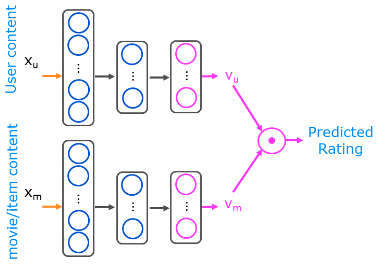

#### Training Data
The movie content provided to the network is a combination of the original data and some 'engineered features'. Recall the feature engineering discussion and lab from Course 1, Week 2, lab 4. The original features are the year the movie was released and the movie's genre's presented as a one-hot vector. There are 14 genres. The engineered feature is an average rating derived from the user ratings. 

The user content is composed of engineered features. A per genre average rating is computed per user. Additionally, a user id, rating count and rating average are available but not included in the training or prediction content. They are carried with the data set because they are useful in interpreting data.

The training set consists of all the ratings made by the users in the data set. Some ratings are repeated to boost the number of training examples of underrepresented genre's. The training set is split into two arrays with the same number of entries, a user array and a movie/item array.  

Below, let's load and display some of the data.

In [4]:
# Utilities

from collections import defaultdict
import csv
import numpy as np
from numpy import genfromtxt
import pickle
import tabulate

def load_data():
    ''' called to load preprepared data for the lab '''
    item_train = genfromtxt('./data/content_item_train.csv', delimiter=',')
    user_train = genfromtxt('./data/content_user_train.csv', delimiter=',')
    y_train    = genfromtxt('./data/content_y_train.csv', delimiter=',')
    with open('./data/content_item_train_header.txt', newline='') as f:    #csv reader handles quoted strings better
        item_features = list(csv.reader(f))[0]
    with open('./data/content_user_train_header.txt', newline='') as f:
        user_features = list(csv.reader(f))[0]
    item_vecs = genfromtxt('./data/content_item_vecs.csv', delimiter=',')

    movie_dict = defaultdict(dict)
    count = 0
#    with open('./data/movies.csv', newline='') as csvfile:
    with open('./data/content_movie_list.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for line in reader:
            if count == 0:
                count += 1  #skip header
                #print(line) print
            else:
                count += 1
                movie_id = int(line[0])
                movie_dict[movie_id]["title"] = line[1]
                movie_dict[movie_id]["genres"] = line[2]

    with open('./data/content_user_to_genre.pickle', 'rb') as f:
        user_to_genre = pickle.load(f)

    return(item_train, user_train, y_train, item_features, user_features, item_vecs, movie_dict, user_to_genre)


def pprint_train(x_train, features, vs, u_s, maxcount=5, user=True):
    """ Prints user_train or item_train nicely """
    if user:
        flist = [".0f", ".0f", ".1f",
                 ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f"]
    else:
        flist = [".0f", ".0f", ".1f", 
                 ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f"]

    head = features[:vs]
    if vs < u_s: print("error, vector start {vs} should be greater then user start {u_s}")
    for i in range(u_s):
        head[i] = "[" + head[i] + "]"
    genres = features[vs:]
    hdr = head + genres
    disp = [split_str(hdr, 5)]
    count = 0
    for i in range(0, x_train.shape[0]):
        if count == maxcount: break
        count += 1
        disp.append([x_train[i, 0].astype(int),
                     x_train[i, 1].astype(int),
                     x_train[i, 2].astype(float),
                     *x_train[i, 3:].astype(float)
                    ])
    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=flist, numalign='center')
    return table


def split_str(ifeatures, smax):
    ''' split the feature name strings to tables fit '''
    ofeatures = []
    for s in ifeatures:
        if not ' ' in s:  # skip string that already have a space
            if len(s) > smax:
                mid = int(len(s)/2)
                s = s[:mid] + " " + s[mid:]
        ofeatures.append(s)
    return ofeatures
    

def print_pred_movies(y_p, item, movie_dict, maxcount=10):
    """ print results of prediction of a new user. inputs are expected to be in
        sorted order, unscaled. """
    count = 0
    disp = [["y_p", "movie id", "rating ave", "title", "genres"]]

    for i in range(0, y_p.shape[0]):
        if count == maxcount:
            break
        count += 1
        movie_id = item[i, 0].astype(int)
        disp.append([np.around(y_p[i, 0], 1), item[i, 0].astype(int), np.around(item[i, 2].astype(float), 1),
                     movie_dict[movie_id]['title'], movie_dict[movie_id]['genres']])

    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow")
    return table

def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict maxtrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (num_items, 1))
    return user_vecs

# predict on  everything, filter on print/use
def predict_uservec(user_vecs, item_vecs, model, u_s, i_s, scaler):
    """ given a scaled user vector, does the prediction on all movies in scaled print_item_vecs returns
        an array predictions sorted by predicted rating,
        arrays of user and item, sorted by predicted rating sorting index
    """
    y_p = model.predict([user_vecs[:, u_s:], item_vecs[:, i_s:]])
    y_pu = scaler.inverse_transform(y_p)

    if np.any(y_pu < 0):
        print("Error, expected all positive predictions")
    sorted_index = np.argsort(-y_pu, axis=0).reshape(-1).tolist()  #negate to get largest rating first
    sorted_ypu   = y_pu[sorted_index]
    sorted_items = item_vecs[sorted_index]
    sorted_user  = user_vecs[sorted_index]
    return(sorted_index, sorted_ypu, sorted_items, sorted_user)
                
def get_user_vecs(user_id, user_train, item_vecs, user_to_genre):
    """ given a user_id, return:
        user train/predict matrix to match the size of item_vecs
        y vector with ratings for all rated movies and 0 for others of size item_vecs """

    if not user_id in user_to_genre:
        print("error: unknown user id")
        return None
    else:
        user_vec_found = False
        for i in range(len(user_train)):
            if user_train[i, 0] == user_id:
                user_vec = user_train[i]
                user_vec_found = True
                break
        if not user_vec_found:
            print("error in get_user_vecs, did not find uid in user_train")
        num_items = len(item_vecs)
        user_vecs = np.tile(user_vec, (num_items, 1))

        y = np.zeros(num_items)
        for i in range(num_items):  # walk through movies in item_vecs and get the movies, see if user has rated them
            movie_id = item_vecs[i, 0]
            if movie_id in user_to_genre[user_id]['movies']:
                rating = user_to_genre[user_id]['movies'][movie_id]
            else:
                rating = 0
            y[i] = rating
    return(user_vecs, y)

def get_item_genres(item_gvec, genre_features):
    ''' takes in the item's genre vector and list of genre names
    returns the feature names where gvec was 1 '''
    offsets = np.nonzero(item_gvec)[0]
    genres = [genre_features[i] for i in offsets]
    return genres


def print_existing_user(y_p, y, user, items, ivs, uvs, movie_dict, maxcount=10):
    """ print results of prediction for a user who was in the database.
        Inputs are expected to be in sorted order, unscaled.
    """
    count = 0
    disp = [["y_p", "y", "user", "user genre ave", "movie rating ave", "movie id", "title", "genres"]]
    count = 0
    for i in range(0, y.shape[0]):
        if y[i, 0] != 0:  # zero means not rated
            if count == maxcount:
                break
            count += 1
            movie_id = items[i, 0].astype(int)

            offsets = np.nonzero(items[i, ivs:] == 1)[0]
            genre_ratings = user[i, uvs + offsets]
            disp.append([y_p[i, 0], y[i, 0],
                         user[i, 0].astype(int),      # userid
                         np.array2string(genre_ratings, 
                                         formatter={'float_kind':lambda x: "%.1f" % x},
                                         separator=',', suppress_small=True),
                         items[i, 2].astype(float),    # movie average rating
                         movie_id,
                         movie_dict[movie_id]['title'],
                         movie_dict[movie_id]['genres']])

    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=[".1f", ".1f", ".0f", ".2f", ".1f"])
    return table

In [5]:
# Load the Data Set
# Set Configuration Variables
item_train, user_train, y_train, item_features, user_features, item_vecs, movie_dict, user_to_genre = load_data()

num_user_features = user_train.shape[1] - 3  # Remove: userid, rating count, and ave rating during training
num_item_features = item_train.shape[1] - 1  # Remove: movie id at train time

uvs = 3  # user genre vector start
ivs = 3  # item genre vector start
u_s = 3  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items

print(f"Number of Training Vectors: {len(item_train)}")

Number of Training Vectors: 50884


In [6]:
print(f"Number of User Features: {num_user_features}")
print(f"Number of Item Features: {num_item_features}")

Number of User Features: 14
Number of Item Features: 16


Let's look at the first few entries in the user training array.

In [7]:
pprint_train(user_train, user_features, uvs,  u_s, maxcount=5)

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9


Some of the user and item/movie features are not used in training. In the table above, the features in brackets "[]" such as the "user id", "rating count" and "rating ave" are not included when the model is trained and used.
Above you can see the per genre rating average for user 2. Zero entries are genre's which the user had not rated. The user vector is the same for all the movies rated by a user.  
Let's look at the first few entries of the movie/item array.

In [8]:
pprint_train(item_train, item_features, ivs, i_s, maxcount=5, user=False)

[movie id],year,ave rating,Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
6874,2003,4.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
8798,2004,3.8,1,0,0,0,0,1,0,1,0,0,0,0,0,1
46970,2006,3.2,1,0,0,0,1,0,0,0,0,0,0,0,0,0
48516,2006,4.3,0,0,0,0,0,1,0,1,0,0,0,0,0,1
58559,2008,4.2,1,0,0,0,0,1,0,1,0,0,0,0,0,0


Above, the movie array contains the year the film was released, the average rating and an indicator for each potential genre. The indicator is one for each genre that applies to the movie. The movie id is not used in training but is useful when interpreting the data.

In [9]:
print(f"y_train[:5]: {y_train[:5]}")

y_train[:5]: [4.  3.5 4.  4.  4.5]


The target, y, is the movie rating given by the user. 

Above, we can see that movie 6874 is an Action/Crime/Thriller movie released in 2003. User 2 rates action movies as 3.9 on average. MovieLens users gave the movie an average rating of 4. 'y' is 4 indicating user 2 rated movie 6874 as a 4 as well. A single training example consists of a row from both the user and item arrays and a rating from y_train.

#### Preparing the Training Data
Recall in Course 1, Week 2, you explored feature scaling as a means of improving convergence. We'll scale the input features using the [scikit learn StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). This was used in Course 1, Week 2, Lab 5.  Below, the inverse_transform is also shown to produce the original inputs. We'll scale the target ratings using a Min Max Scaler which scales the target to be between -1 and 1. [scikit learn MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [10]:
# Scale the Training Data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled    = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))
#ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train)))
print(np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))

True
True


To allow us to evaluate the results, we will split the data into training and test sets as was discussed in Course 2, Week 3. Here we will use [sklean train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split and shuffle the data. Note that setting the initial random state to the same value ensures item, user, and y are shuffled identically.

In [11]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)

print(f"Movie/Item Training Data Shape: {item_train.shape}")
print(f"Movie/Item Test Data Shape: {item_test.shape}")

Movie/Item Training Data Shape: (40707, 17)
Movie/Item Test Data Shape: (10177, 17)


The scaled, shuffled data now has a mean of zero.

In [12]:
pprint_train(user_train, user_features, uvs, u_s, maxcount=5)

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
1,0,-1.0,-0.8,-0.7,0.1,-0.0,-1.2,-0.4,0.6,-0.5,-0.5,-0.1,-0.6,-0.6,-0.7,-0.7
0,1,-0.7,-0.5,-0.7,-0.1,-0.2,-0.6,-0.2,0.7,-0.5,-0.8,0.1,-0.0,-0.6,-0.5,-0.4
-1,-1,-0.2,0.3,-0.4,0.4,0.5,1.0,0.6,-1.2,-0.3,-0.6,-2.3,-0.1,0.0,0.4,-0.0
0,-1,0.6,0.5,0.5,0.2,0.6,-0.1,0.5,-1.2,0.9,1.2,-2.3,-0.1,0.0,0.2,0.3
-1,0,0.7,0.6,0.5,0.3,0.5,0.4,0.6,1.0,0.6,0.3,0.8,0.8,0.4,0.7,0.7


### Neural Network for Content-Based Filtering
Now, let's construct a neural network as described in the figure above. It will have two networks that are combined by a dot product. You will construct the two networks. In this example, they will be identical. Note that these networks do not need to be the same. If the user content was substantially larger than the movie content, you might elect to increase the complexity of the user network relative to the movie network. In this case, the content is similar, so the networks are the same.

- Use a Keras sequential model
    - The first layer is a dense layer with 256 units and a relu activation.
    - The second layer is a dense layer with 128 units and a relu activation.
    - The third layer is a dense layer with `num_outputs` units and a linear or no activation.   
    
The remainder of the network will be provided. The provided code does not use the Keras sequential model but instead uses the Keras [functional api](https://keras.io/guides/functional_api/). This format allows for more flexibility in how components are interconnected.

In [13]:
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_outputs, activation="linear")
])

item_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_outputs, activation="linear")
])

# Create the User Input and Point to the Base Setwork
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# Create the ıTEM Input and Point to the Base Setwork
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the Dot Product of the Two Vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# Specify the Inputs and Output of the Model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 14)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32)                   40864     ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32)                   41376     ['input_2[0][0]']             
                                                                                              

2023-08-26 00:27:34.061125: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-26 00:27:34.061145: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-26 00:27:34.061149: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-26 00:27:34.061177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-26 00:27:34.061190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


We will use a Mean Squared Error Loss and an Adam Optimizer.

In [14]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

In [15]:
tf.random.set_seed(1)
model.fit([user_train[:, u_s:], item_train[:, i_s:]], y_train, epochs=30)

Epoch 1/30


2023-08-26 00:27:34.460986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1273/1273 [==============================] - 10s 8ms/step - loss: 0.2220
Epoch 2/30
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1963
Epoch 3/30
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1826
Epoch 4/30
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1732
Epoch 5/30
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1596
Epoch 6/30
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1450
Epoch 7/30
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1403
Epoch 8/30
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1365
Epoch 9/30
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1348
Epoch 10/30
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1329
Epoch 11/30
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1323
Epoch 12/30
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1309


Evaluate the model to determine loss on the test data. 

In [16]:
model.evaluate([user_test[:, u_s:], item_test[:, i_s:]], y_test)

 41/319 [==>...........................] - ETA: 1s - loss: 0.1301

2023-08-26 00:32:32.999050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


319/319 [==============================] - 1s 4ms/step - loss: 0.1236


0.123562291264534

It is comparable to the training loss indicating the model has not substantially overfit the training data.

### Predictions
Below, you'll use your model to make predictions in a number of circumstances. 

#### Predictions for a New User
First, we'll create a new user and have the model suggest movies for that user. After you have tried this on the example user content, feel free to change the user content to match your own preferences and see what the model suggests. Note that ratings are between 0.5 and 5.0, inclusive, in half-step increments.

In [17]:
new_user_id = 5000
new_rating_ave = 0.0
new_action = 0.0
new_adventure = 5.0
new_animation = 0.0
new_childrens = 0.0
new_comedy = 0.0
new_crime = 0.0
new_documentary = 0.0
new_drama = 0.0
new_fantasy = 5.0
new_horror = 0.0
new_mystery = 0.0
new_romance = 0.0
new_scifi = 0.0
new_thriller = 0.0
new_rating_count = 3

user_vec = np.array([[new_user_id, new_rating_count, new_rating_ave,
                      new_action, new_adventure, new_animation, new_childrens,
                      new_comedy, new_crime, new_documentary,
                      new_drama, new_fantasy, new_horror, new_mystery,
                      new_romance, new_scifi, new_thriller]])

The new user enjoys movies from the adventure, fantasy genres. Let's find the top-rated movies for the new user.  
Below, we'll use a set of movie/item vectors, `item_vecs` that have a vector for each movie in the training/test set. This is matched with the new user vector above and the scaled vectors are used to predict ratings for all the movies.

In [18]:
# generate and replicate the user vector to match the number movies in the data set.
user_vecs = gen_user_vecs(user_vec,len(item_vecs))

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display

print_pred_movies(sorted_ypu, sorted_items, movie_dict, maxcount = 10)

27/27 [==============================] - 0s 3ms/step


2023-08-26 00:32:34.324395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


y_p,movie id,rating ave,title,genres
3.7,7156,4.3,"Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)",Documentary
3.7,80906,4.3,Inside Job (2010),Documentary
3.5,77455,4,Exit Through the Gift Shop (2010),Comedy|Documentary
3.5,6331,3.9,Spellbound (2002),Documentary
3.4,27846,3.9,"Corporation, The (2003)",Documentary
3.4,54881,3.9,"King of Kong, The (2007)",Documentary
3.3,5669,3.8,Bowling for Columbine (2002),Documentary
3.1,4973,4.2,"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Comedy|Romance
3,53894,3.7,Sicko (2007),Documentary|Drama
3,5618,4.2,Spirited Away (Sen to Chihiro no kamikakushi) (2001),Adventure|Animation|Fantasy


#### Predictions for an Existing User
Let's look at the predictions for "user 2", one of the users in the data set. We can compare the predicted ratings with the model's ratings.

In [19]:
uid = 2 
# form a set of user vectors. This is the same vector, transformed and repeated.
user_vecs, y_vecs = get_user_vecs(uid, user_train_unscaled, item_vecs, user_to_genre)

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display
sorted_user  = user_vecs[sorted_index]
sorted_y     = y_vecs[sorted_index]

#print sorted predictions for movies rated by the user
print_existing_user(sorted_ypu, sorted_y.reshape(-1,1), sorted_user, sorted_items, ivs, uvs, movie_dict, maxcount = 50)

27/27 [==============================] - 0s 2ms/step


y_p,y,user,user genre ave,movie rating ave,movie id,title,genres
4.3,5.0,2,[4.0],4.3,80906,Inside Job (2010),Documentary
4.2,3.0,2,"[4.0,4.0]",4.0,77455,Exit Through the Gift Shop (2010),Comedy|Documentary
3.8,4.5,2,"[4.0,4.1,4.0]",4.2,58559,"Dark Knight, The (2008)",Action|Crime|Drama
3.8,4.5,2,"[4.0,4.0]",4.1,68157,Inglourious Basterds (2009),Action|Drama
3.8,4.0,2,"[4.1,4.0,3.9]",4.3,48516,"Departed, The (2006)",Crime|Drama|Thriller
3.7,4.0,2,[4.0],4.0,112552,Whiplash (2014),Drama
3.6,3.0,2,[3.9],4.0,109487,Interstellar (2014),Sci-Fi
3.6,5.0,2,"[4.0,4.1,4.0]",3.9,106782,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama
3.6,3.5,2,"[4.0,4.2,4.1]",4.0,91529,"Dark Knight Rises, The (2012)",Action|Adventure|Crime
3.6,3.5,2,"[4.0,4.0]",3.9,99114,Django Unchained (2012),Action|Drama


The model prediction is generally within 1 of the actual rating though it is not a very accurate predictor of how a user rates specific movies. This is especially true if the user rating is significantly different than the user's genre average. You can vary the user id above to try different users. Not all user id's were used in the training set.

#### Finding Similar Items
The neural network above produces two feature vectors, a user feature vector $v_u$, and a movie feature vector, $v_m$. These are 32 entry vectors whose values are difficult to interpret. However, similar items will have similar vectors. This information can be used to make recommendations. For example, if a user has rated "Toy Story 3" highly, one could recommend similar movies by selecting movies with similar movie feature vectors.

A similarity measure is the squared distance between the two vectors $ \mathbf{v_m^{(k)}}$ and $\mathbf{v_m^{(i)}}$ :
$$\left\Vert \mathbf{v_m^{(k)}} - \mathbf{v_m^{(i)}}  \right\Vert^2 = \sum_{l=1}^{n}(v_{m_l}^{(k)} - v_{m_l}^{(i)})^2\tag{1}$$

In [20]:
def sq_dist(a,b):
    """
    Returns the squared distance between two vectors.
    Args:
      a (ndarray (n,)): vector with n features
      b (ndarray (n,)): vector with n features
    Returns:
      d (float) : distance
    """
    d = 0
    n = a.shape[0]
    for i in range(n):
        d += (a[i] - b[i])**2
    return d

In [21]:
a1 = np.array([1.0, 2.0, 3.0]); b1 = np.array([1.0, 2.0, 3.0])
a2 = np.array([1.1, 2.1, 3.1]); b2 = np.array([1.0, 2.0, 3.0])
a3 = np.array([0, 1, 0]);       b3 = np.array([1, 0, 0])

# Expected Output: 0.000, 0.030, 2.000 Respectively
print(f"Squared Distance between a1 and b1: {sq_dist(a1, b1):0.3f}")
print(f"Squared Distance between a2 and b2: {sq_dist(a2, b2):0.3f}")
print(f"Squared Distance between a3 and b3: {sq_dist(a3, b3):0.3f}")

Squared Distance between a1 and b1: 0.000
Squared Distance between a2 and b2: 0.030
Squared Distance between a3 and b3: 2.000


A matrix of distances between movies can be computed once when the model is trained and then reused for new recommendations without retraining. The first step, once a model is trained, is to obtain the movie feature vector, $v_m$, for each of the movies. To do this, we will use the trained `item_NN` and build a small model to allow us to run the movie vectors through it to generate $v_m$.

In [22]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features))    # Input Layer
vm_m = item_NN(input_item_m)                                       # Use the Trained item_NN
vm_m = tf.linalg.l2_normalize(vm_m, axis=1)                        # Incorporate Normalization as was Done in the Original Model
model_m = tf.keras.Model(input_item_m, vm_m)                                
model_m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16)]              0         
                                                                 
 sequential_1 (Sequential)   (None, 32)                41376     
                                                                 
 tf.math.l2_normalize_2 (TF  (None, 32)                0         
 OpLambda)                                                       
                                                                 
Total params: 41376 (161.62 KB)
Trainable params: 41376 (161.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Once you have a movie model, you can create a set of movie feature vectors by using the model to predict using a set of item/movie vectors as input. `item_vecs` is a set of all of the movie vectors. It must be scaled to use with the trained model. The result of the prediction is a 32 entry feature vector for each movie.

In [23]:
scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs[:,i_s:])
print(f"Size of all Predicted Movie Feature Vectors: {vms.shape}")

27/27 [==============================] - 0s 2ms/step
Size of all Predicted Movie Feature Vectors: (847, 32)


2023-08-26 00:32:34.624017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Let's now compute a matrix of the squared distance between each movie feature vector and all other movie feature vectors:
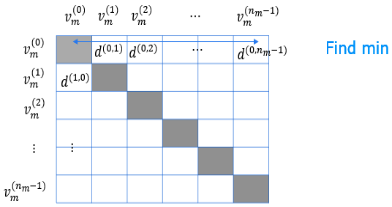

We can then find the closest movie by finding the minimum along each row. We will make use of [numpy masked arrays](https://numpy.org/doc/1.21/user/tutorial-ma.html) to avoid selecting the same movie. The masked values along the diagonal won't be included in the computation.

In [24]:
count = 50   # Number of Movies to Display
dim = len(vms)
dist = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        dist[i,j] = sq_dist(vms[i, :], vms[j, :])
        
m_dist = ma.masked_array(dist, mask=np.identity(dist.shape[0]))  # mask the diagonal

disp = [["movie1", "genres", "movie2", "genres"]]
for i in range(count):
    min_idx = np.argmin(m_dist[i])
    movie1_id = int(item_vecs[i,0])
    movie2_id = int(item_vecs[min_idx,0])
    disp.append( [movie_dict[movie1_id]['title'], movie_dict[movie1_id]['genres'],
                  movie_dict[movie2_id]['title'], movie_dict[movie1_id]['genres']]
               )
table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow")
table

movie1,genres,movie2,genres
Save the Last Dance (2001),Drama|Romance,Mona Lisa Smile (2003),Drama|Romance
"Wedding Planner, The (2001)",Comedy|Romance,"Sweetest Thing, The (2002)",Comedy|Romance
Hannibal (2001),Horror|Thriller,Bad Boys II (2003),Horror|Thriller
Saving Silverman (Evil Woman) (2001),Comedy|Romance,"Muppets, The (2011)",Comedy|Romance
Down to Earth (2001),Comedy|Fantasy|Romance,Bewitched (2005),Comedy|Fantasy|Romance
"Mexican, The (2001)",Action|Comedy,Rush Hour 2 (2001),Action|Comedy
15 Minutes (2001),Thriller,Panic Room (2002),Thriller
Enemy at the Gates (2001),Drama,"Aviator, The (2004)",Drama
Heartbreakers (2001),Comedy|Crime|Romance,"Animal, The (2001)",Comedy|Crime|Romance
Spy Kids (2001),Action|Adventure|Children|Comedy,Scooby-Doo (2002),Action|Adventure|Children|Comedy
